<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_2_5_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
!pip install darts --quiet

In [53]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from darts.utils.statistics import plot_acf as plot_acf_d, check_seasonality, plot_pacf
from darts.models import NaiveSeasonal, NaiveDrift, XGBModel, ExponentialSmoothing, AutoARIMA, ARIMA, Theta, Prophet, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train=pd.read_csv('drive/MyDrive/ML_course/train_store.csv')
train['date']=pd.to_datetime(train['date'])
train.set_index('date', inplace=True)
train.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [5]:
def calculate_confidence_interval(data):
    mean = np.mean(data)
    confidence = 0.95
    h = st.t.interval(confidence, len(data) - 1, loc=mean, scale=st.sem(data))
    return mean, h

def analyze_sales(df, item_id):
    df=df.reset_index()
    item_data = df[df['item'] == item_id]
    monthly_sales = item_data.groupby(pd.Grouper(key='date', freq='M'))['sales'].apply(list)
    results = {}
    for month, sales in monthly_sales.items():
        mean, ci = calculate_confidence_interval(sales)
        results[month] = {'mean': mean, 'min': ci[0], 'max':ci[1]}
    return pd.DataFrame(results).T

ci= analyze_sales(train,1)

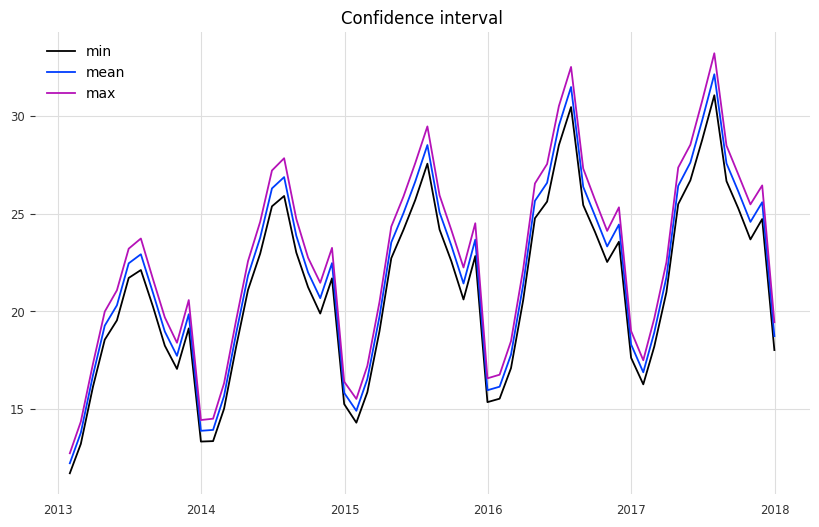

In [6]:
fig=plt.figure(figsize=(10,6))
plt.plot(ci['min'], label='min')
plt.plot(ci['mean'], label='mean')
plt.plot(ci['max'], label='max')
plt.title('Confidence interval')
plt.legend()
plt.show()

In [7]:
sales_by_store=train.groupby(['store','item'])['sales'].mean().reset_index()

In [8]:
fig=px.bar(sales_by_store, x='store', y='sales', color='item', title='Average sales by store')
fig.update_layout(title_x=0.5)

In [9]:
train['month']=train.index.strftime(date_format='%Y-%m')

In [10]:
store_group=train.groupby(['store','month'])['sales'].mean().reset_index()

In [11]:
fig=px.line(store_group, x='month', y='sales', color='store', title='Dynamic of average sales by store')
fig.update_layout(title_x=0.5)

In [12]:
item_group=train.groupby(['item','month'])['sales'].mean().reset_index()

In [13]:
fig=px.line(item_group, x='month', y='sales', color='item', title='Dynamic of average sales by item')
fig.update_layout(title_x=0.5)

Спостерігається сезонність як для кожного з товарів та і загалом по магазинах. Пікові продажі в липні кожного року. Від початку року до липня спостерігається підвищення продажів і до кінця року продажі йдуть на спад. Найвищі показники продадів у 2 та 8 магазинів. Видно тренд на зростання продажів з часом, а також збільшується варіативність даних протягом року (більша різниця між мінімумом та максимумом продажів протягом року).

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [14]:
import plotly.graph_objects as go

In [15]:
train_m=pd.DataFrame(train[train['item']==1].groupby('month')['sales'].mean()).reset_index()

In [16]:
item1=train[(train.item==1)&(train.store==1)]

In [17]:
item1_month=item1.groupby('month')['sales'].mean().reset_index()

In [18]:
train_month=train[train['item']==1].groupby('month')['sales'].mean()
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_m['month'], y=train_m['sales'], name='store 1'))
fig.add_trace(go.Scatter(x=item1_month['month'], y=item1_month['sales'], name='all stores'))
fig.update_layout(title='Comparing dynamic of sales of item 1 for store 1 vs all stores', title_x=0.5)
fig.show()

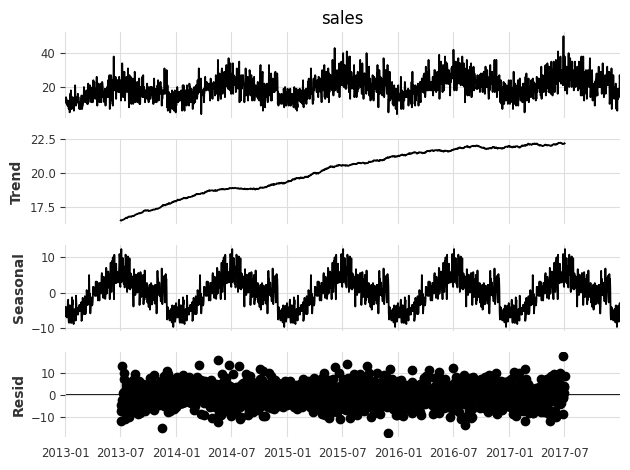

In [52]:
decomp_add=seasonal_decompose(item1['sales'], model='additive', period=365)
decomp_add.plot();

In [43]:
result = adfuller(item1['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Є тренд на зростання продажів, видна чітка річна сезонність. Розмір залишків мені здається досить великим (від -10 до 10), враховуючи діапазон значень. Динаміка продажів 1 товару в 1 магазині та в усіх інших магазинах має схожу тенденцію. Та в цілому ці графки повторюють патерни, які є на попередніх графіках (продажі в розрізі магазинів та товарів). Для кращого сприйняття візуалізацій я вивела середнє значення за місяць замість відображення щоденних показників. За результатами тесту Дікі-Фуллера часовий ряд є стаціонарним та не потребує додаткових дій для досягнення стаціонарності.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [20]:
from darts import TimeSeries

In [21]:
item1_series=TimeSeries.from_dataframe(item1, value_cols='sales')

<Axes: xlabel='date'>

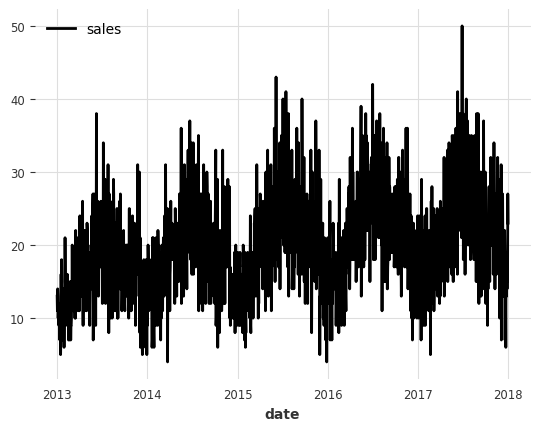

In [22]:
item1_series.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [23]:
item1_train, item1_val=item1_series.split_before(pd.Timestamp('2017-10-01'))

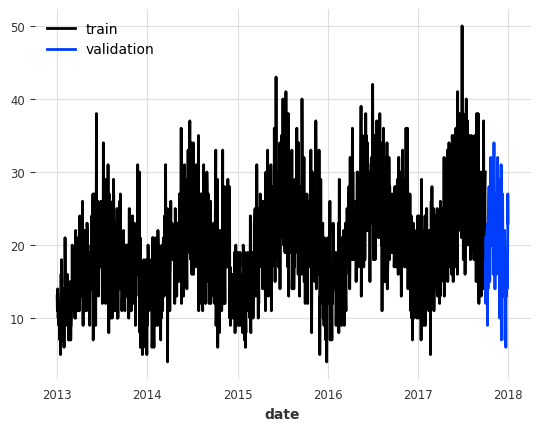

In [24]:
item1_train.plot(label='train')
item1_val.plot(label='validation');

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

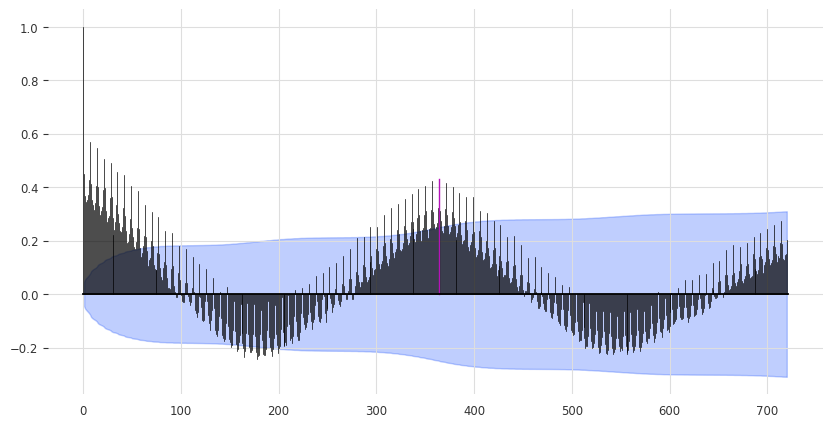

In [25]:
plot_acf_d(item1_series, max_lag=720, alpha=0.05, m=364)

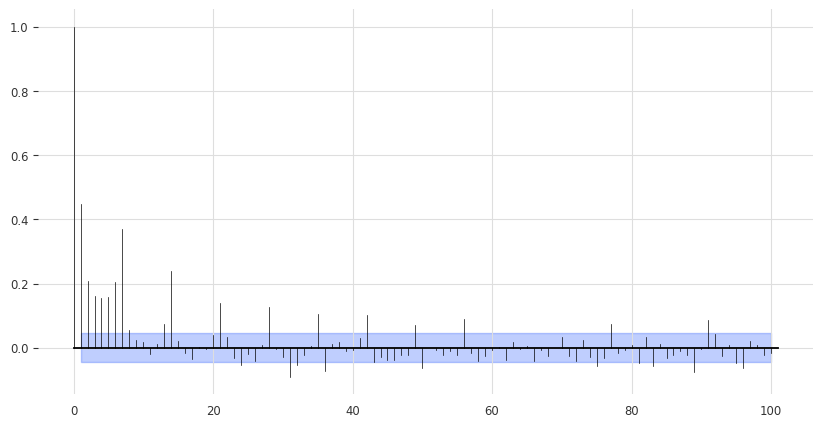

In [26]:
plot_pacf(item1_series, max_lag=100, alpha=0.05)

Лаги до 90 та від 360 орієнтовно до 400 є важливими, що вказує на наявність різних типів сезонності, як місячної, квартальної так і річної.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [27]:
for m in range(2, 720):
    is_seasonal, period = check_seasonality(item1_series, m=m, alpha=0.05, max_lag=720)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 147.
There is seasonality of order 217.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

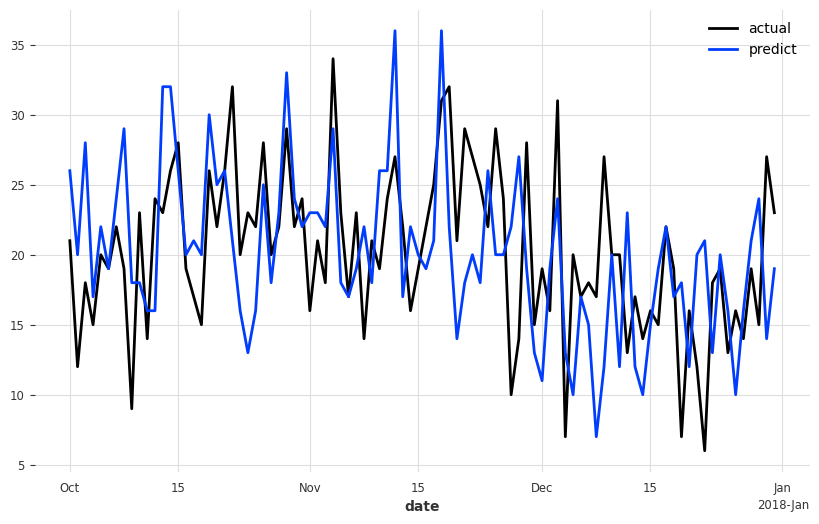

In [28]:
naive_season=NaiveSeasonal(K=364)
naive_season.fit(item1_train)
predict_season=naive_season.predict(92)
plt.figure(figsize=(10, 6))
item1_val.plot(label='actual')
predict_season.plot(label='predict');

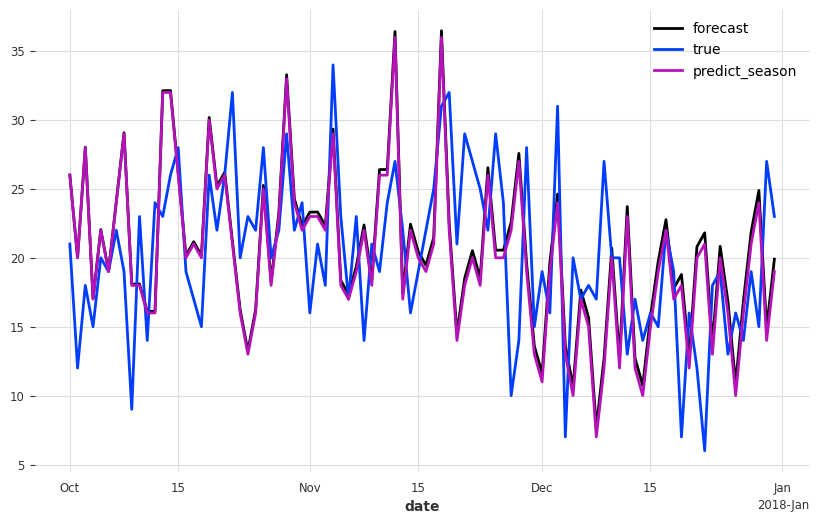

In [57]:
naive_drift=NaiveDrift()
naive_drift.fit(item1_train)
naive_predict=naive_drift.predict(92)
drift_forecast=predict_season+naive_predict-item1_train.last_value()
plt.figure(figsize=(10, 6))
drift_forecast.plot(label='forecast')
item1_val.plot(label='true')
predict_season.plot(label='predict_season');

Модель має досить погану точність. MAPE 31,8% та 32,2% для Naive Season та Naive Drift відповідно.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [58]:
mape(item1_val, predict_season )

31.794044496096348

In [59]:
mape(item1_val, drift_forecast)

32.20862438117553

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [32]:
xgbmodel=XGBModel(lags=364,
                  output_chunk_length=1,
                  n_estimators=100,
                  max_depth=3,
                 learning_rate=0.1
                  )
xgbmodel.fit(item1_train)
xgb_pred=xgbmodel.predict(92)
mape(item1_val, xgb_pred)

25.54431951361159

In [33]:
def enrich_with_date_features(df):
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

In [34]:
series_enrich=enrich_with_date_features(item1_series.to_dataframe().reset_index())

In [35]:
future_covariates=TimeSeries.from_dataframe(series_enrich.drop('sales', axis=1).set_index('date'))

In [36]:
train_cov, val_cov=future_covariates.split_before(pd.Timestamp('2017-10-01'))

In [37]:
scaler=Scaler()
train_transformed=scaler.fit_transform(item1_train)
val_transformed=scaler.transform(item1_val)
scaler_cov=Scaler()
train_cov_transf=scaler_cov.fit_transform(train_cov)
val_cov_transf=scaler_cov.transform(val_cov)

In [38]:
model=XGBModel(lags=31,
                  output_chunk_length=1,
                  n_estimators=300,
                  max_depth=3,
                 learning_rate=0.1,
               lags_future_covariates=[0])
model.fit(train_transformed, future_covariates=train_cov_transf)
pred=model.predict(92, future_covariates=val_cov_transf)
val_pred=scaler.inverse_transform(pred)
mape(item1_val, val_pred)

23.6044996630821

Якість моделі покращилась також завдяки додаванням коваріат (додаткових ознак з дати, а також масштабуванню змінних). І також покращилась якість завдяки зменшенню лагу з 364 до 31.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [39]:
from darts.utils.utils import ModelMode, SeasonalityMode

In [40]:
exp_model=ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=364)
exp_model.fit(item1_train)
exp_pred=exp_model.predict(92)
mape(item1_val, exp_pred)

25.38377730001865

Якість моделі не покращилась порівняно з XGBoost. Додавання коваріат та масштабування ознак в даному випадку не дало кращий результат. Дана точність вияивлась максимальною на оригінальному тренувальному наборі. Але точність стала трохи вищою за рахунок комбінації адитивного тренду та мультиплікативної сезонності.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [41]:
arima_model=ARIMA(p=7, d=0, q=1)
arima_model.fit(item1_train)
arima_pred=arima_model.predict(92)
mape(item1_val, arima_pred)

30.463527461536113

In [42]:
sarima=ARIMA(p=1, d=0, q=1, seasonal_order=(1,1,1,31))
sarima.fit(item1_train)
sarima_pred=arima_model.predict(92)
mape(item1_val, sarima_pred)

30.463527461536113

Моделі мають низьку точність, близьку до якості наївних моделей. Модель з лагом 364 не вдалось натренувати через довгу тривалість навчання. Можливо, це одна з причин, чому в даному випадку вийшла низька точність. Знайдені оптимальні параметри за допомогою AutoARIMA теж дають поганий результат.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [44]:
auto_model=AutoARIMA(start_p=1, max_p=365, start_q=1)
auto_model.fit(item1_train)
auto_pred=auto_model.predict(92)
mape(item1_val, auto_pred)

39.52818304458719

In [45]:
auto_model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Tue, 01 Apr 2025   AIC                          10591.078
Time:                        17:04:56   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [46]:
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(item1_train, future_covariates=train_cov_transf)
forecast =prophet_model.predict(92, future_covariates=val_cov_transf)
mape(item1_val, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/op_7rzce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/2_puewvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75443', 'data', 'file=/tmp/tmpsqdpc5ez/op_7rzce.json', 'init=/tmp/tmpsqdpc5ez/2_puewvc.json', 'output', 'file=/tmp/tmpsqdpc5ez/prophet_modelu52ybfj0/prophet_model-20250401170457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


22.964708138941887

Дана модель показує найкращий результат порівняно з іншими, також точність вдалось підвищити завдяки масштабуванню ознак та додаванню коваріат.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [47]:
rnn_model = RNNModel(model='LSTM', input_chunk_length=1,  output_chunk_length=92,  n_epochs=100, random_state=42)
rnn_model.fit(item1_train)
forecast = rnn_model.predict(92)
mape(item1_val, forecast)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

30.895254841395833

Модель дає результати на рівні ARIMA/SARIMA.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [48]:
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(item1_train, future_covariates=train_cov_transf)
forecast =prophet_model.predict(92, future_covariates=val_cov_transf)
mape(item1_val, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/p1oz657l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/shl4fk0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21984', 'data', 'file=/tmp/tmpsqdpc5ez/p1oz657l.json', 'init=/tmp/tmpsqdpc5ez/shl4fk0p.json', 'output', 'file=/tmp/tmpsqdpc5ez/prophet_modelx_o518g1/prophet_model-20250401170818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


22.964708138941887

In [49]:
hfc_params = {
    "series": item1_train,
    "start": pd.Timestamp("2016-10-01"),
    "forecast_horizon": 91,
    "verbose": True,
}

historical_fcast = prophet_model.historical_forecasts( last_points_only=True, **hfc_params)

historical forecasts:   0%|          | 0/275 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/qtq9_6do.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/_szi0ozg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93920', 'data', 'file=/tmp/tmpsqdpc5ez/qtq9_6do.json', 'init=/tmp/tmpsqdpc5ez/_szi0ozg.json', 'output', 'file=/tmp/tmpsqdpc5ez/prophet_model2a1_1xin/prophet_model-20250401170818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/275 [00:00<02:43,  1.67it/s]INFO:prophet

In [50]:
mape(item1_train, historical_fcast)

20.071859796904338

historical forecasts:   0%|          | 0/4 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/ui6ffki2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqdpc5ez/5lz6ugwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43128', 'data', 'file=/tmp/tmpsqdpc5ez/ui6ffki2.json', 'init=/tmp/tmpsqdpc5ez/5lz6ugwc.json', 'output', 'file=/tmp/tmpsqdpc5ez/prophet_model0c9ocilk/prophet_model-20250401171010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:  25%|██▌       | 1/4 [00:00<00:01,  2.83it/s]INFO:prophet:Dis

MAPE = 20.35%


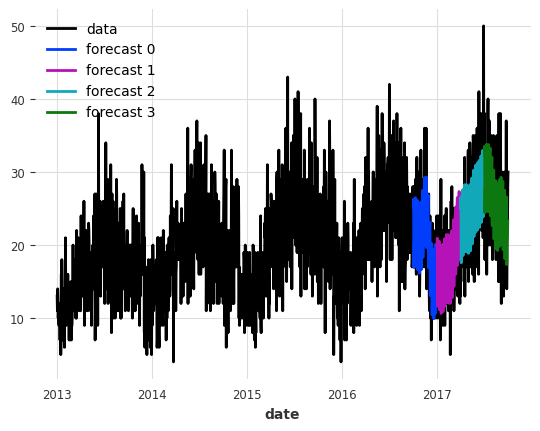

In [51]:
historical_fcast_all = prophet_model.historical_forecasts(last_points_only=False, stride=91, **hfc_params)

item1_train.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(item1_train, historical_fcast_all):.2f}%")

За допомогою бектестингу вдалось покращити MAPE до 20.07%. З графіку видно, що модель не може передбачити максимальні та мінімальні значення, хоча і передбачає сезонність та тренд. Як було видно з графіків декомпозиції на початку помилки мають великі значення  модель не навчилась їх передбачати.

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Серед моделей для прогнозування я би обрала Prophet, оскільки вона дає найкращий результат. Для прогнозування даних для 50 товарів я би використала 18 моделей, виходячи з графіку продажів по кожному з товарів, осільки графіки деяких товарів накладаються один на одного і чітко виділяються 18 груп товарів. Можливо, варто би ще було спробувати додатково якось стабілізувати часовий ряд (хоча і результати показують, що ряд стабільний), щоб якось зменшити розмір помилок та їх вплив на кінцевий результат (частину помилки може вивести в якийсь сезонний компонент?)